# Measuring risk 

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

logging.basicConfig(level=logging.CRITICAL)

from lightgbm.sklearn import LGBMRegressor
from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.estimators import MLPRegressor, MultiOutputRegressor, RidgeCV
from skfin.metrics import sharpe_ratio
from skfin.mv_estimators import MeanVariance
from skfin.plot import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

returns_data = load_kf_returns(filename="38_Industry_Portfolios", cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"].replace(
    -99.99, np.nan
)

transform_X = lambda x: x.rolling(12).mean().fillna(0)
transform_y = lambda x: x.shift(-1)
features = transform_X(ret)
target = transform_y(ret)

For a given portfolio $h_{\Phi}$ using the covariance $V_{\Phi}$, the metric that we use is the `risk-bias` given by 

$$ \text {RiskBias}_{\Phi}  = Std \left[\frac{h_{\Phi}^T r}{\sqrt{h^T V_{\Phi} h }} \right] -1 , $$
where the variance is evaluated over empirical returns. 

The returns $r_t$ are over $N$ assets (so that $r_t$ is a vector of size $N$). The covariance of returns is: 
$$V = Var(r_t).$$ 

Performing a singular value decomposition of $V$ yields: 

$$ V = U S U^T,$$

where $U$ contains the eigenvectors and $S$ is a diagonal matrix with the eigenvalues. Each eigenvector can be considered as the weight of factor and we construct the factor returns as: 

$$ f_t = U^T r_t.$$ 

**Lemma**: the factors $f_t$ are uncorrelated and their volatility is by the eigenvalue. 

*Prof*. $ Var(f_t) = U^T Var(r_t) U = U^T U S U^T U = S.$

**Lemma**: the eigenvector associated to the largest eigenvalue maximizes $u^T V u$ such that $u^T u = 1$. 

*Proof*. Introducing the Lagrange multiplier $\xi$ on the constraint, the first-order condition is 

$$ V u = \xi u, $$

so that $u$ is an eigenvector and the value of the objective is the eigenvalue associated to $u$. So the objective is maximized for the largest eigenvalue. 


**Corollary**:  the eigenvector associated to the smallest eigenvalue minimizes $u^T V u$ such that $u^T u = 1$. 

## Return covariance eigenvalues

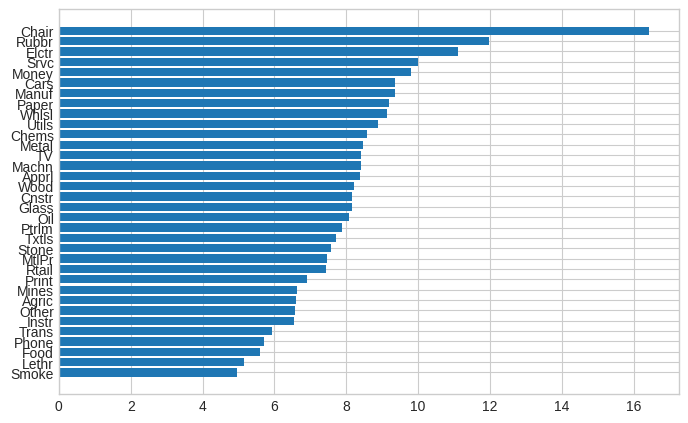

In [2]:
T = 60
X = ret.iloc[:T].dropna(how="all", axis=1)
bar(X.std().sort_values(), horizontal=True)

In [3]:
u, s, _ = np.linalg.svd(X.cov())

In [4]:
mode_returns = X.dot(u)

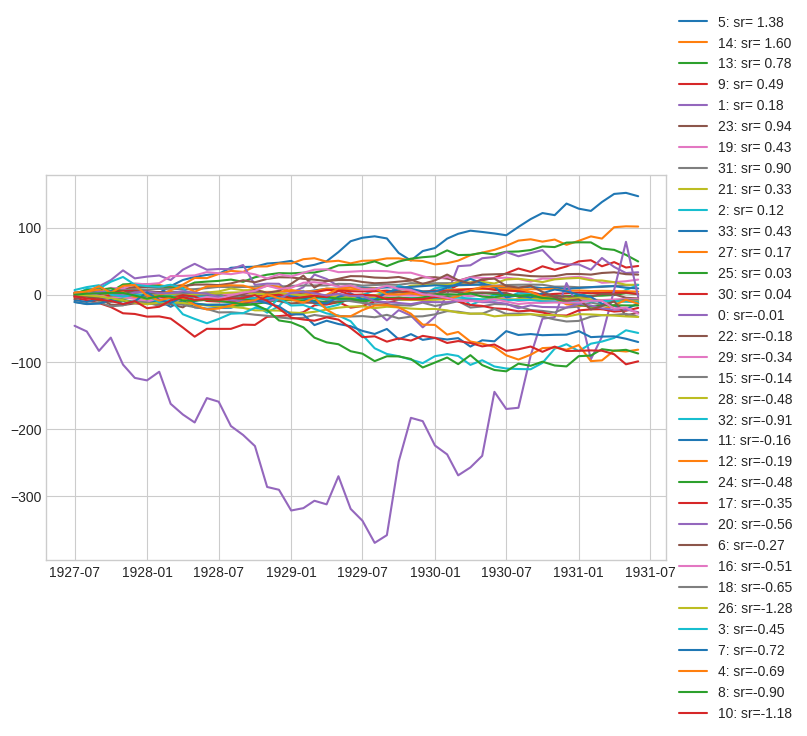

In [5]:
line(mode_returns, cumsum=True, legend=True)

The graph below shows that the largest eigenvalue is two-order of magnitude larger than the smallest one. 

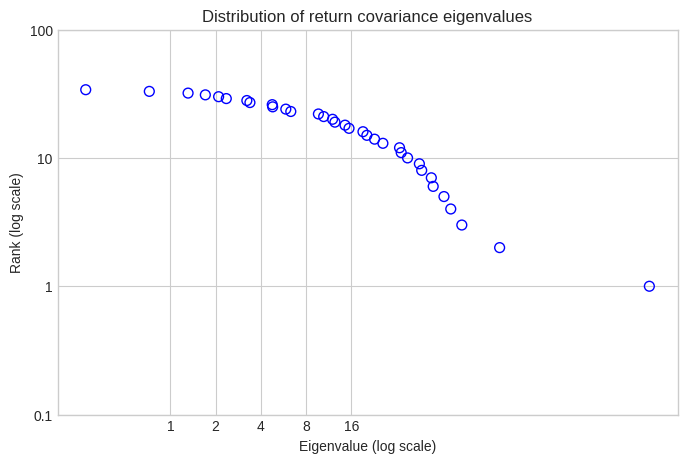

In [6]:
df = pd.Series(s, np.arange(1, X.shape[1] + 1))
scatter(
    df,
    xscale="log",
    yscale="log",
    xlabel="Eigenvalue (log scale)",
    ylabel="Rank (log scale)",
    xticks=[1, 2, 4, 8, 16],
    yticks=[0.1, 1, 10, 100],
    title="Distribution of return covariance eigenvalues",
)

In [7]:
print(f"The ratio of the largest to the smallest eigenvalue is {s[0] / s[-1]:.1f}")

The ratio of the largest to the smallest eigenvalue is 5671.4


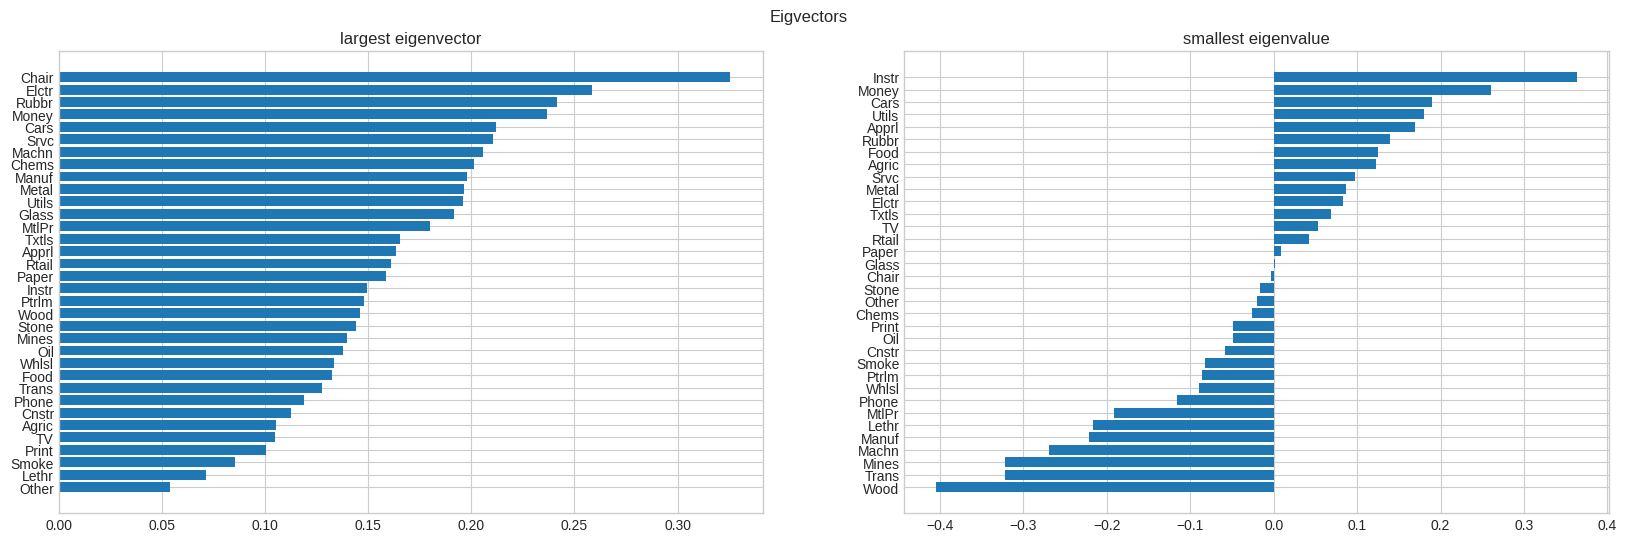

In [8]:
d = {
    "largest eigenvector": pd.Series(u[:, 0] / np.sign(np.mean(u[:, 0])), X.columns),
    "smallest eigenvalue": pd.Series(u[:, -1] / np.sign(np.mean(u[:, 1])), X.columns),
}
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Eigvectors", y=0.95)
for i, (k, v) in enumerate(d.items()):
    bar(v, title=k, ax=ax[i], horizontal=True)

The Lemma and corollary above show that the eigenvalues measure the *in-sample* variance of a mode. But how well does the in-sample variance predicts the out-of-sample variance? 

To test assess this point, we construct the pnls of modes (defined as the portfolio with the eigenvectors as positions), normalized by the ex-ante standard deviation (as the square-root of the eigenvalue) and signed so that the in-sample pnl is positive.  

In [9]:
from sklearn.model_selection import TimeSeriesSplit

start_date = "1945-01-01"
test_size = 1
params = dict(max_train_size=T, test_size=test_size, gap=0)
params["n_splits"] = 1 + len(ret.loc[start_date:]) // test_size

cv = TimeSeriesSplit(**params)

In [10]:
mode_pnl = []
for train, test in cv.split(ret):
    V_ = ret.fillna(0).iloc[train].cov()
    u, s, _ = np.linalg.svd(V_)
    retain_max = np.sum([v > 1e-5 for v in s])
    s[retain_max:] = np.nan * s[retain_max:]
    mu = ret.iloc[train].fillna(0).dot(u).mean()
    mode_pnl += [ret.fillna(0).iloc[test].dot(u).mul(np.sign(mu)).div(np.sqrt(s))]
mode_pnl = pd.concat(mode_pnl)

The graph below shows the out-of-sample risk of each mode pnl which has been rescaled to unit ex-ante risk (so that the natural baseline is 1). This metric is called a `risk bias` and will be defined formally in the next section. We see that for the first largest modes, the risk bias is close to 1, so that the ex-ante risk measures well the out-of-sample risk. However, for the smallest modes, this ex-ante meausre is completely off. For the smallest modes, the positions "overfit" information from the covariance matrix (in particular the correlation) and it is intuitive that the small in-sample risk estimates mean-revert to larger out-of-sample volatility.  

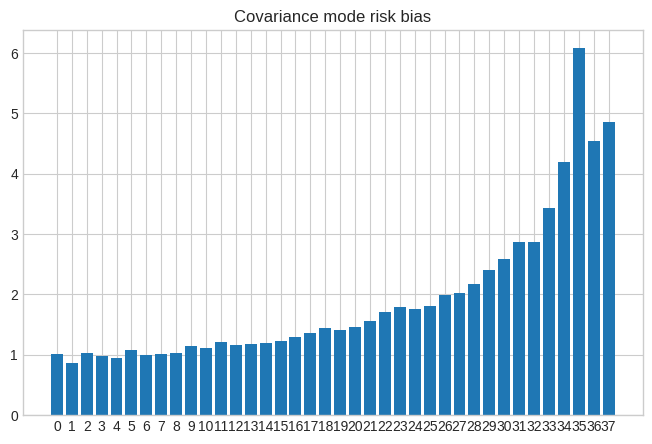

In [11]:
bar(mode_pnl.std(), sort=False, title="Covariance mode risk bias")

## Marcenko-Pastur

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import norm


def marcenko_pastur_pdf(x, q, sigma=1):
    """Marcenko-Pastur Probability Density Function (PDF)."""
    b = sigma**2 * (1 + np.sqrt(1 / q)) ** 2
    a = sigma**2 * (1 - np.sqrt(1 / q)) ** 2
    if a < 0:
        a = 0
    pdf = np.zeros_like(x, dtype=float)

    mask = (x >= a) & (x <= b)
    pdf[mask] = (1 / (2 * np.pi * sigma**2 * x[mask] * q)) * np.sqrt(
        (b - x[mask]) * (x[mask] - a)
    )

    return pdf

In [13]:
T, N = X.shape

In [14]:
V_ = X.iloc[:T].cov()
u, s, _ = np.linalg.svd(V_)

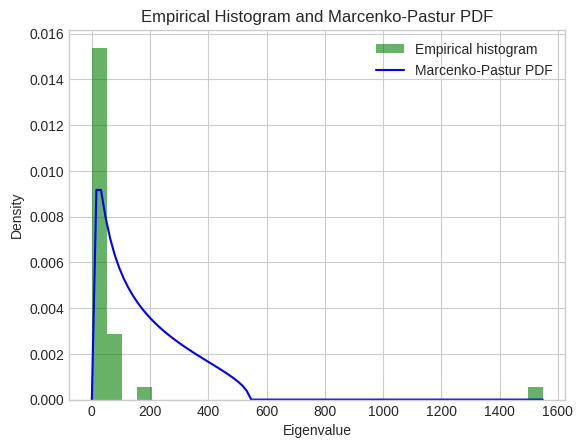

In [15]:
plt.hist(s, bins=30, density=True, alpha=0.6, color="g", label="Empirical histogram")

# Compute the Marcenko-Pastur distribution
q = N / T
x = np.linspace(s.min(), s.max(), 100)
mp_pdf = marcenko_pastur_pdf(x, q, sigma=10)

# Plot the Marcenko-Pastur distribution
plt.plot(x, mp_pdf, color="blue", label="Marcenko-Pastur PDF")

# Add labels and legend
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.title("Empirical Histogram and Marcenko-Pastur PDF")
plt.legend()
plt.grid(True)

## Understanding covariance shrinkage

Simple shrinkage: 

$$V_{\omega} = \omega \times Diag(V) + (1-\omega) \times V.$$

$$V_{\omega} =  \frac{\omega  Tr(V)}{N} \times I_N + (1 - \omega) \times V $$

In [16]:
from sklearn.covariance import ShrunkCovariance


def simple_shrunk_covariance(x, shrinkage):
    v = np.cov(x.T)
    return shrinkage * np.diag(np.diag(v)) + (1 - shrinkage) * v

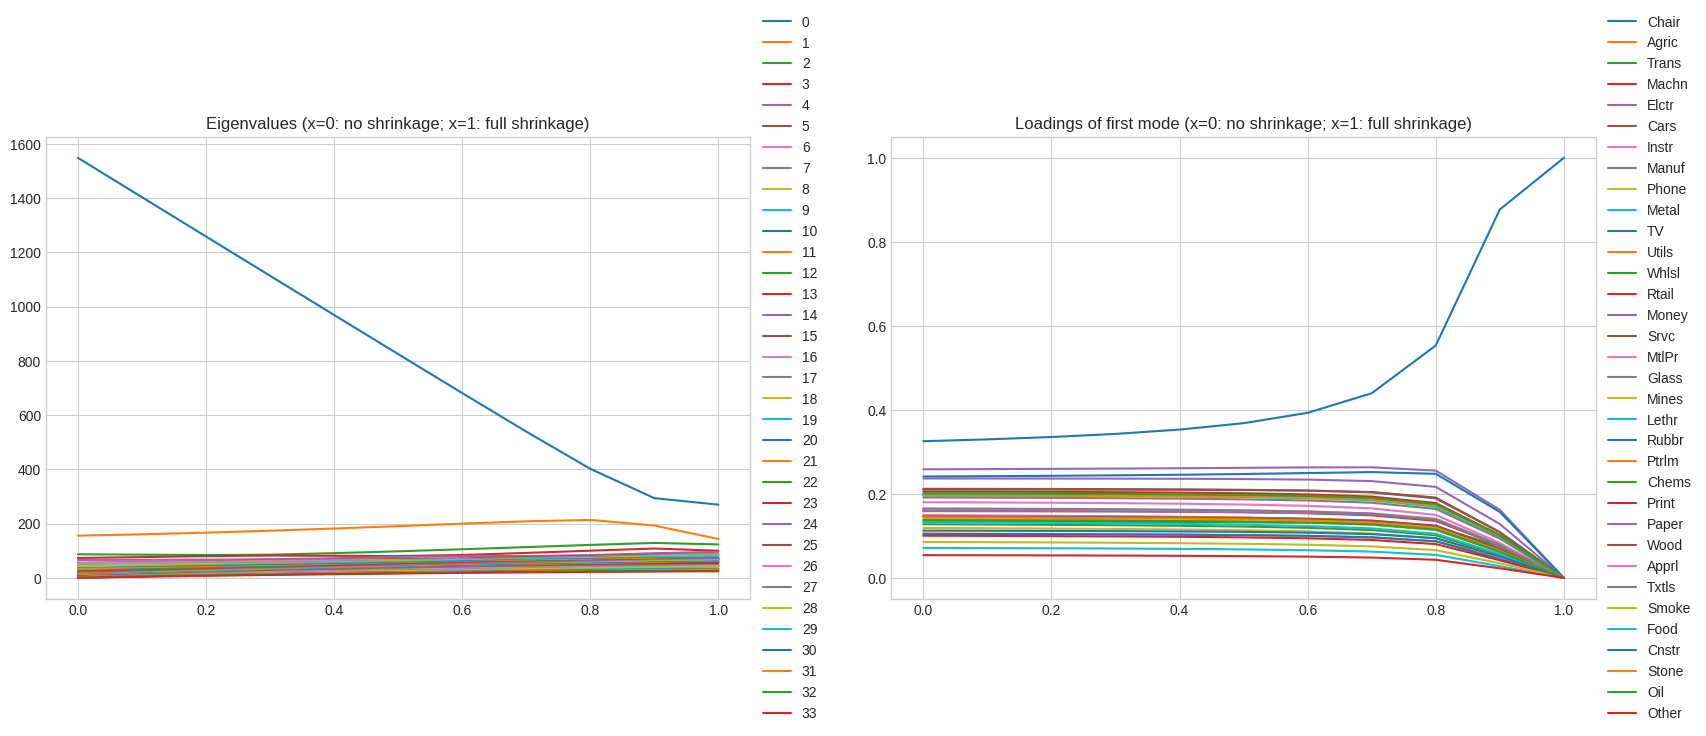

In [17]:
S = {}
U0 = {}
for shrinkage in np.arange(0, 1.1, 0.1):
    V_ = shrinkage * np.diag(np.diag(X.cov())) + (1 - shrinkage) * X.cov()
    u, s, _ = np.linalg.svd(V_)
    S[shrinkage] = s
    U0[shrinkage] = u[:, 0] * np.sign(np.mean(u[:, 0]))
S = pd.DataFrame.from_dict(S, orient="index")
U0 = pd.DataFrame.from_dict(U0, orient="index").rename(
    columns={i: c for i, c in enumerate(X.columns)}
)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
line(S, title="Eigenvalues (x=0: no shrinkage; x=1: full shrinkage)", ax=ax[0])

line(
    U0,
    title="Loadings of first mode (x=0: no shrinkage; x=1: full shrinkage)",
    ax=ax[1],
)

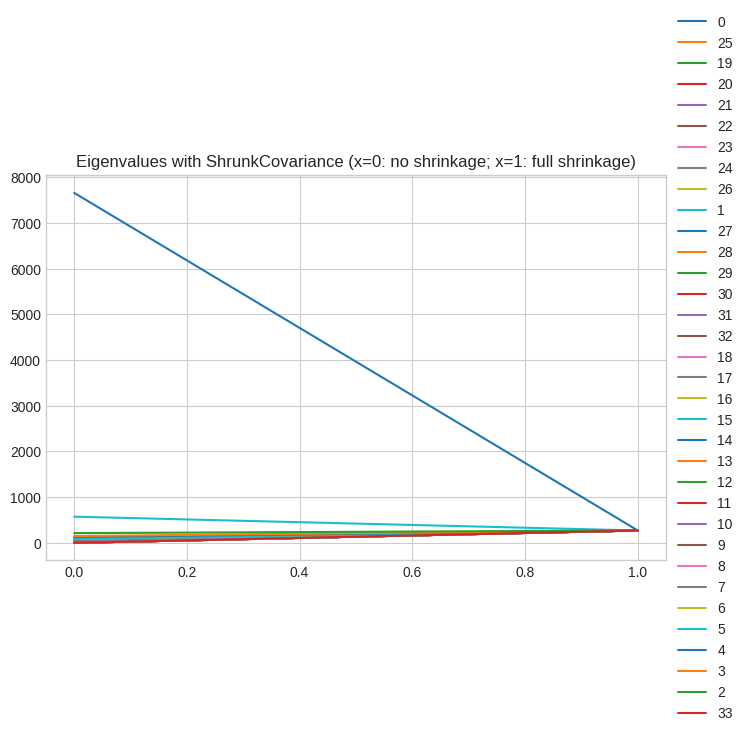

In [18]:
S = {}
for shrinkage in np.arange(0, 1.01, 0.1):
    V_ = ShrunkCovariance(shrinkage=shrinkage).fit(X.cov()).covariance_
    _, s, _ = np.linalg.svd(V_)
    S[shrinkage] = s
S = pd.DataFrame.from_dict(S, orient="index")

line(
    S,
    title="Eigenvalues with ShrunkCovariance (x=0: no shrinkage; x=1: full shrinkage)",
)